In [6]:
# TODO
# Collect at least 1000 gray image
# resize them 32X32 (1024)
# construct data matrix and covariance matrix using face image
# SVD ( PCA ) to the covariance matrix
# eigenvectors for largest singular values
# FINAL : Test for the recognition

In [7]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

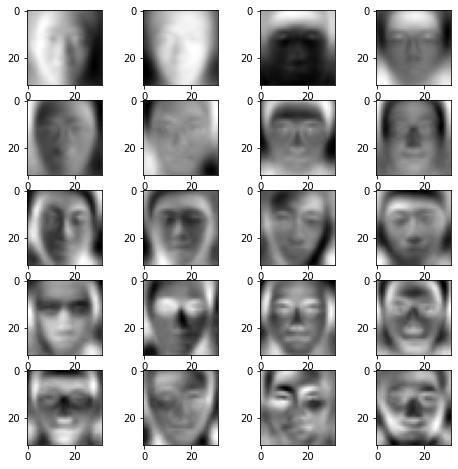

In [8]:
file_M_path = "./res/faces/M/"
file_F_path = "./res/faces/F/"
file_M_list = os.listdir("./res/faces/M/")
file_F_list = os.listdir("./res/faces/F/")
sharpening_1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])

man_pics = []
for file_M in file_M_list:
    man_pics.append(np.array(
        cv2.resize(cv2.imread(file_M_path + file_M, 0), dsize=(32, 32), interpolation=cv2.INTER_AREA)
    ,dtype=np.float64).flatten())

sum_of_pics = sum(man_pics)

mean_of_pics = sum_of_pics / len(man_pics)

translation = man_pics - mean_of_pics

U, s, V = np.linalg.svd(translation, full_matrices = True)

S = np.zeros(translation.shape)
for i in range(len(s)):
     S[i][i] = s[i]

appA = np.dot(U, np.dot(S, V))

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = V[i].reshape(32,32)
#     img = l[np.random.randint(1024)].reshape(32,32)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()

In [60]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontface.xml')
test_file_list = os.listdir("./res/test/")
for i, file_path in enumerate(test_file_list):
    frame = cv2.imread("./res/test/" + file_path)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    cv2.putText(frame, "", (5,15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0 ,255), 1)
    if len(faces):
        x,y,w,h = faces[0]
        cv2.imwrite("result-" + str(i) + ".jpg", frame[y:y+h, x:x+w])


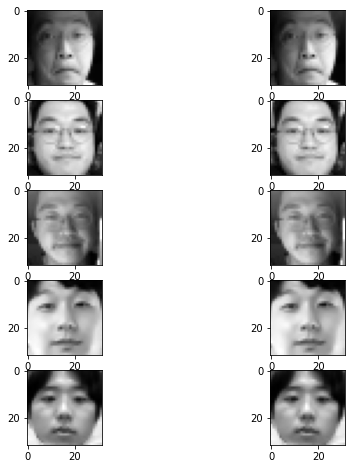

In [58]:
test_file_list = os.listdir("./res/test/")
test_pics = []
weights = []
for test_file in test_file_list:
    pic = np.array(cv2.resize(cv2.imread("./res/test/" + test_file, 0), dsize=(32, 32), interpolation=cv2.INTER_AREA), dtype=np.float64).flatten()
    test_pics.append(pic)
    weights.append((pic - mean_of_pics) @ V.T)

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = len(test_file_list)
for i in range(rows):
    original_img = test_pics[i].reshape(32,32)
    w = np.diag(weights[i])
    restored_img = w @ V
    restored_img = (sum(restored_img[:1024]) + mean_of_pics).reshape(32, 32)
    fig.add_subplot(rows, columns, 2*i + 1)
    plt.imshow(original_img, cmap='gray')
    fig.add_subplot(rows, columns, 2*i + 2)
    plt.imshow(restored_img, cmap='gray')
plt.show()

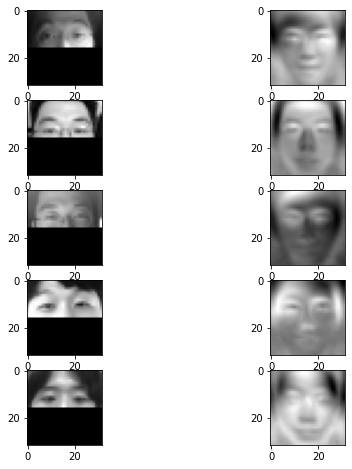

In [59]:
test_file_list = os.listdir("./res/test/")
test_pics = []
weights = []
for test_file in test_file_list:
    pic = np.array(cv2.resize(cv2.imread("./res/test/" + test_file, 0), dsize=(32, 32), interpolation=cv2.INTER_AREA), dtype=np.float64).flatten()
    test_pics.append(pic)
#     ll = np.concatenate(((pic - mean_of_pics)[:512], np.array([1 for i in range(512)])))
    ll = np.concatenate(((pic - mean_of_pics)[:512],  np.array([1/512 for i in range(512)])))
    weights.append(ll @ V.T)

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = len(test_file_list)
for i in range(rows):
    original_img = np.concatenate((test_pics[i][:512], np.array([1 for i in range(512)]))).reshape(32,32)
    w = np.diag(weights[i])
    restored_img = w @ V
    restored_img = (sum(restored_img[:24])).reshape(32, 32)
    fig.add_subplot(rows, columns, 2*i + 1)
    plt.imshow(original_img, cmap='gray')
    fig.add_subplot(rows, columns, 2*i + 2)
    plt.imshow(restored_img, cmap='gray')
plt.show()